Import necessary library

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import folium
import math
import requests
from pandas.io.json import json_normalize

Import station information that was previouly downloaded

In [2]:
path = 'C:\\Users\\salom\\Desktop\\BIXI2018\\Stations_2018.csv'
station_info = pd.read_csv(path)
print(station_info.shape)
station_info.head()

(552, 4)


,code,name,latitude,longitude
0,7030,de Bordeaux / Marie-Anne,45.533409,-73.570657
1,6141,de Bordeaux / Rachel,45.532270,-73.568280
2,6100,Mackay / de Maisonneuve,45.496590,-73.578510
3,6064,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070
4,6730,35e avenue / Beaubien,45.570081,-73.573047


Visualize the Stations

In [3]:
map_montreal = folium.Map(location=[45.516136, -73.656830], zoom_start=11)

for code, name, lat, long in zip(station_info['code'], station_info['name'], station_info['latitude'], station_info['longitude']):
    label = '{}: {}'.format(code, name)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, long],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_montreal)
    
map_montreal

import trip data

In [4]:
path04 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-04.csv'
path05 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-05.csv'
path06 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-06.csv'
path07 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-07.csv'
path08 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-08.csv'
path09 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-09.csv'
path10 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-10.csv'
path11 = 'C:\\Users\\salom\\Desktop\\BIXI2018\\OD_2018-11.csv'

trips04 = pd.read_csv(path04)
trips05 = pd.read_csv(path05)
trips06 = pd.read_csv(path06)
trips07 = pd.read_csv(path07)
trips08 = pd.read_csv(path08)
trips09 = pd.read_csv(path09)
trips10 = pd.read_csv(path10)
trips11 = pd.read_csv(path11)

trips = pd.concat([trips04, trips05, trips06, trips07, trips08, trips09, trips10, trips11], axis = 0)

del(trips04, trips05, trips06, trips07, trips08, trips09, trips10, trips11)

trips["start_date"] = pd.to_datetime(trips["start_date"])
trips["end_date"] = pd.to_datetime(trips["end_date"])

print(trips.shape)
trips.head()

(5277541, 6)


,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2018-04-10 11:56:00,7030,2018-04-10 11:57:00,6141,87,1
1,2018-04-10 11:56:00,6100,2018-04-10 11:59:00,6064,122,1
2,2018-04-10 11:57:00,6730,2018-04-10 12:16:00,6396,1132,1
3,2018-04-10 11:58:00,6108,2018-04-10 12:02:00,6114,271,1
4,2018-04-10 12:01:00,6223,2018-04-10 12:10:00,6233,513,1


Add important columns

In [5]:
trips['month'] = trips['start_date'].dt.month
trips['week_day'] = trips['start_date'].dt.dayofweek
trips['hour'] = trips['start_date'].dt.hour
trips.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,month,week_day,hour
0,2018-04-10 11:56:00,7030,2018-04-10 11:57:00,6141,87,1,4,1,11
1,2018-04-10 11:56:00,6100,2018-04-10 11:59:00,6064,122,1,4,1,11
2,2018-04-10 11:57:00,6730,2018-04-10 12:16:00,6396,1132,1,4,1,11
3,2018-04-10 11:58:00,6108,2018-04-10 12:02:00,6114,271,1,4,1,11
4,2018-04-10 12:01:00,6223,2018-04-10 12:10:00,6233,513,1,4,1,12


Count arrivals and departments

In [6]:
start_count = trips.groupby('start_station_code').count()
start_count = start_count.iloc[:,[0]]
start_count.columns = ['start_count']
start_count.index.names = ['station_code']
start_count.head()

,start_count
station_code,
4000,8036
4001,5477
4002,12143
5002,427
5003,345


In [7]:
end_count = trips.groupby('end_station_code').count()
end_count = end_count.iloc[:,[0]]
end_count.columns = ['end_count']
end_count.index.names = ['station_code']
end_count.head()

,end_count
station_code,
4000,10863
4001,5431
4002,14549
5002,576
5003,431


In [8]:
station_location = station_info.set_index(station_info['code'])
station_location = station_location.loc[:,['latitude', 'longitude']]
station_location.sort_index(inplace = True)
station_location.index.names = ['station_code']
station_location.head()

,latitude,longitude
station_code,,
4000,45.549457,-73.541649
4001,45.502629,-73.527750
4002,45.506194,-73.569968
5002,45.533682,-73.515261
5003,45.528410,-73.517166


add location data

In [9]:
trip_count = start_count.join(end_count).join(station_location)
trip_count['net_arrival'] = trip_count['end_count']-trip_count['start_count']
trip_count.head()

,start_count,end_count,latitude,longitude,net_arrival
station_code,,,,,
4000,8036,10863,45.549457,-73.541649,2827
4001,5477,5431,45.502629,-73.527750,-46
4002,12143,14549,45.506194,-73.569968,2406
5002,427,576,45.533682,-73.515261,149
5003,345,431,45.528410,-73.517166,86


Plot the arrivals and departures using folium. Green indicates net arrival and Red net departures.

In [10]:
migration_map = folium.Map(location=[45.516136, -73.656830], zoom_start=11)

for index, row in trip_count.iterrows():
    radius = math.sqrt(abs(row['net_arrival']/100))  #we take the square root because we want the area proportions to represent the arrival/departures
    if row['net_arrival']>0:
        color="green"
    else:
        color="red" 
    
    folium.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius=radius,
                        color=color,
                        fill=True).add_to(migration_map)

migration_map

the location should be close to where people arrive

we will calculate a 3d function that represents the possible outflow of people after they arrive 

In [11]:
folium.Rectangle([[45.500352, -73.578578], [45.518348, -73.550200]]).add_to(migration_map) 

migration_map

we only use net arrivals for calculating the foot score

In [12]:
stations_of_interest = trip_count[trip_count['net_arrival'] > 0]
stations_of_interest.head()

,start_count,end_count,latitude,longitude,net_arrival
station_code,,,,,
4000,8036,10863,45.549457,-73.541649,2827
4002,12143,14549,45.506194,-73.569968,2406
5002,427,576,45.533682,-73.515261,149
5003,345,431,45.528410,-73.517166,86
5004,574,659,45.539824,-73.508752,85


In [13]:
def get_foot_rate(lat, long):
    foot = []
    for i in range(len(stations_of_interest['start_count'])):
        dist = np.sqrt((lat-stations_of_interest.loc[stations_of_interest.index[i],'latitude'])**2+(long-stations_of_interest.loc[stations_of_interest.index[i],'longitude'])**2)
        w_foot = stations_of_interest.loc[stations_of_interest.index[i],'net_arrival']*math.exp(-dist*100) #the probability of people passing by decreases exponentially with distance 
        foot = foot + [w_foot]
    score = sum(foot)
    
    return score

In [14]:
X = np.arange(-73.578578, -73.550200, step = -(-73.578578+73.550200)/200)
Y = np.arange(45.518348, 45.500352, step = -(45.518348-45.500352)/200)

In [15]:
foot_table = pd.DataFrame(np.zeros(shape =(40000,3)))
foot_table.columns = ['latitude', 'longitude', 'foot_score']
foot_table.head()

,latitude,longitude,foot_score
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [16]:
for i in range(200):
    for j in range(200):
        foot_table.loc[200*i+j, 'latitude'] = Y[i]
        foot_table.loc[200*i+j, 'longitude'] = X[j]

Check for each of the 40000 points

In [17]:
foot_table.head()

,latitude,longitude,foot_score
0,45.518348,-73.578578,0.0
1,45.518348,-73.578436,0.0
2,45.518348,-73.578294,0.0
3,45.518348,-73.578152,0.0
4,45.518348,-73.578010,0.0


In [18]:
for i in range(len(foot_table['latitude'])):
    foot_table.loc[i,'foot_score'] = get_foot_rate(foot_table.loc[i,'latitude'],foot_table.loc[i,'longitude'])

In [19]:
foot_table.head()

,latitude,longitude,foot_score
0,45.518348,-73.578578,40717.580888
1,45.518348,-73.578436,41164.927263
2,45.518348,-73.578294,41616.609911
3,45.518348,-73.578152,42072.659372
4,45.518348,-73.578010,42533.105881


find the max score

In [20]:
print(foot_table.max())
print(foot_table['foot_score'].idxmax())
foot_table.iloc[24922,:]

latitude          45.518348
longitude        -73.550342
foot_score    140421.691501
dtype: float64
24922


latitude          45.507190
longitude        -73.561267
foot_score    140421.691501
Name: 24922, dtype: float64

In [21]:
folium.Circle(
        [foot_table.loc[24922,'latitude'], foot_table.loc[24922,'longitude']],
        radius=40,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(migration_map)

migration_map

In [22]:
trip_time = trips.groupby(['week_day','hour']).count()
trip_time = trip_time['start_date']
trip_time.columns = ['trip_count']
trip_time.head()

week_day  hour
0         0       8137
          1       4497
          2       2850
          3       2567
          4       1384
Name: start_date, dtype: int64

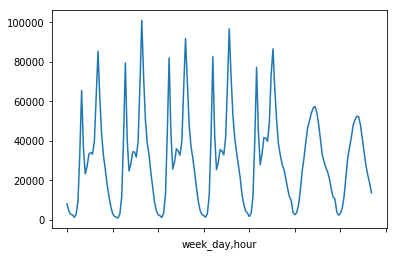

In [23]:
trip_time.plot()

In [24]:
opening_hour = trip_time[trip_time > 30000]
opening_hour

week_day  hour
0         7        33479
          8        65606
          9        36196
          12       33323
          13       34178
          14       33356
          15       39989
          16       62677
          17       85511
          18       61325
          19       43146
          20       32419
1         7        41521
          8        79539
          9        40865
          12       34462
          13       34447
          14       31839
          15       39829
          16       68278
          17      101082
          18       72858
          19       50634
          20       38862
          21       33013
2         7        43309
          8        82059
          9        43945
          12       36006
          13       34982
                   ...  
4         13       41481
          14       39821
          15       49268
          16       73572
          17       86665
          18       66244
          19       50285
          20       38431
          

In [37]:
print('Monday opening hours', opening_hour[0].index)
print('Tuesday opening hours',opening_hour[1].index)
print('Wednesday opening hours',opening_hour[2].index)
print('Thursday opening hours',opening_hour[3].index)
print('Friday opening hours',opening_hour[4].index)
print('Saturday opening hours',opening_hour[5].index)
print('Sunday opening hours',opening_hour[6].index)

Monday opening hours Int64Index([7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', name='hour')
Tuesday opening hours Int64Index([7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype='int64', name='hour')
Wednesday opening hours Int64Index([7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype='int64', name='hour')
Thursday opening hours Int64Index([7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype='int64', name='hour')
Friday opening hours Int64Index([7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype='int64', name='hour')
Saturday opening hours Int64Index([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', name='hour')
Sunday opening hours Int64Index([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64', name='hour')


In [25]:
CLIENT_ID = 'NWRCMJFRU0M4COYJCW3QRRY3ZCZ4GDWGNWYVW1UUP0UBWQHQ' # your Foursquare ID
CLIENT_SECRET = 'KQ1NDSG2T4E2KNRSQLEJ2C2ABO3CUQI4CTNGNEGF4M1PUPJQ' # your Foursquare Secret
latitude = 45.518348
longitude = -73.550342
VERSION = '20180605'
radius = 1000
LIMIT = 1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=NWRCMJFRU0M4COYJCW3QRRY3ZCZ4GDWGNWYVW1UUP0UBWQHQ&client_secret=KQ1NDSG2T4E2KNRSQLEJ2C2ABO3CUQI4CTNGNEGF4M1PUPJQ&ll=45.518348,-73.550342&v=20180605&radius=1000&limit=1000'

In [26]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c4659db9fb6b726620527c7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Ville-Marie',
  'headerFullLocation': 'Ville-Marie, Montreal',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 115,
  'suggestedBounds': {'ne': {'lat': 45.527348009000015,
    'lng': -73.53752131949757},
   'sw': {'lat': 45.50934799099999, 'lng': -73.56316268050243}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0a8608f964a520c62423e3',
       'name': 'Kitchenette',
       'location': {'address': '1351 René-Levesque Est',
        'crossStreet': 'Panet',
        'lat': 45.51890854151511,
        'lng': -73.55234675881643,
        'labeledLatLngs': [{

In [27]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head()

(100, 4)


,name,categories,lat,lng
0,Kitchenette,Gastropub,45.518909,-73.552347
1,La Mer,Fish Market,45.521461,-73.549014
2,Comptoir Lyonnais,French Restaurant,45.519323,-73.551939
3,La Mie Matinale,Bakery,45.520298,-73.554481
4,Renard,Bar,45.519140,-73.555591


In [39]:
cat = nearby_venues.groupby('categories').count()
cat.head()

,name,lat,lng
categories,,,
Adult Boutique,1,1,1
Arts & Crafts Store,1,1,1
Bakery,1,1,1
Bank,1,1,1
Bar,4,4,4


In [43]:
print(cat.idxmax()['name'])
print(cat.max()['name'])

Café
8


We will open a cafe because it is the most thriving business